In [2]:
# works with opence1.51
# it is self contained!
from torch.utils.data import TensorDataset
import torch
import numpy as np
import time
from tqdm import tqdm

import torch.nn as nn
from collections import OrderedDict

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define our MLP model
class SimpleMLP(torch.nn.Module):
    def __init__(self, ninputs=100, nhidden=256, nouts=10, activations='ELU'):
        super().__init__()
        self.layers = OrderedDict([
            ('linear1', nn.Linear(ninputs,nhidden)),
            
            ('act2', nn.ELU()),
            ('dropout1', nn.Dropout()),
            ('linear2', nn.Linear(nhidden,nhidden)),

            ('act2', nn.ELU()),
            ('dropout2', nn.Dropout()),
            ('linear3', nn.Linear(nhidden,nhidden)),

            ('act3', nn.ELU()),
            ('dropout3', nn.Dropout()),
            ('linear4', nn.Linear(nhidden,nouts)),
        ])
        self.net = torch.nn.Sequential(self.layers)
    
    def forward(self, x):
        return self.net(x)

# For easier dataaccess

In [4]:
def getting_datapaths(
    train_idx,
    val_idx,
    files='sunny', 
    target_cols=["ccn_001", "ccn_003", "ccn_006"],
    exclude_cols = ["XLONG", "XLAT"],
):
    # getting colname
    featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
    targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

    featcols = np.load(f"{featloc}/x_name.npy")
    targcols = np.load(f"{targloc}/y_name.npy")
    
    target_idx = [np.where(targcols == i)[0].item() for i in target_cols ]
    feat_idx   = [np.where(featcols == i)[0].item() for i in featcols if i not in exclude_cols]
    
    # getting paths
    if files == 'sunny':
        # my data
        featloc = "/home/kwoksun2/hackathon_data/norm_data"
        targloc = "/home/kwoksun2/hackathon_data/norm_data"

        train_feat_files = [f"{featloc}/t{t}_feat.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/t{t}_feat.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/t{t}_targ.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/t{t}_targ.npy" for t in val_idx]
    
    elif files == 'kedar':
        featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
        targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

        train_feat_files = [f"{featloc}/{t}feat_norm.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/{t}feat_norm.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/{t}targ_norm.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/{t}targ_norm.npy" for t in val_idx]

    return [np.array(train_feat_files),np.array(train_targ_files)], [np.array(val_feat_files),np.array(val_targ_files)], feat_idx, target_idx

In [5]:
from sklearn.model_selection import train_test_split

# THIS IS JUST FOR TESTING!!!!!!!
# WILL CHANGE BACK TO 133 later
nsnapshots = 133

# DONT CHANGE THE SEEEDDDDDD!!!!!
np.random.seed(52)
full_indx = np.arange(nsnapshots)
train_idx, val_idx = train_test_split(full_indx, test_size=0.2, train_size=0.8) 

In [6]:
import torch

# now the data is loaded

# ckpt_path = "/home/kwoksun2/hackathon_data/ep_4_kedar_ccn_001,ccn_003,ccn_006_XLONG,XLAT_MLP.pt"

ckpt_path = "ep_13_sunny_D_ALPHA,D_GAMMA,D_ALPHA_CCN,D_GAMMA_CCN_XLONG,XLAT_MLP.pt"

ckpt = torch.load(ckpt_path)

mlp = ckpt['model_state_dict']

In [7]:
datasource = "sunny" # ckpt['datasource']
exclude_cols =  ckpt['exclude_cols']
target_cols =  ckpt['target_cols']

In [8]:
# getting the idx used in the model
featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

featcols = np.load(f"{featloc}/x_name.npy")
targcols = np.load(f"{targloc}/y_name.npy")

target_idx = [np.where(targcols == i)[0].item() for i in target_cols ]
feat_idx   = [np.where(featcols == i)[0].item() for i in featcols if i not in exclude_cols]

In [9]:
train_files, val_files, feat_idx, target_idx = getting_datapaths(
    train_idx, 
    val_idx, 
    files=datasource, 
    exclude_cols = exclude_cols,
    target_cols  = target_cols
)

In [10]:
# NOW THE EXICING PART MAKING PREDICTIONS YEAHHHH

In [11]:
train_files[0][:3]

array(['/home/kwoksun2/hackathon_data/norm_data/t21_feat.npy',
       '/home/kwoksun2/hackathon_data/norm_data/t95_feat.npy',
       '/home/kwoksun2/hackathon_data/norm_data/t92_feat.npy'],
      dtype='<U53')

In [12]:
feat_files, targ_files = val_files
# we are selecting only the first validation data
feat_data = np.load(feat_files[3])
targ_data = np.load(targ_files[3])

if targ_data.ndim == 1:
    targ_data = targ_data.reshape(10,-1).transpose()

In [13]:
feat_files[0], targ_files[0]

('/home/kwoksun2/hackathon_data/norm_data/t40_feat.npy',
 '/home/kwoksun2/hackathon_data/norm_data/t40_targ.npy')

In [14]:
tds = torch.utils.data.TensorDataset(
    torch.from_numpy(feat_data[:,feat_idx]).float(), 
    torch.from_numpy(targ_data[:,target_idx]).float()
)
dl = torch.utils.data.DataLoader(tds, batch_size=1024, shuffle=False)

In [15]:
target_idx

[5, 6, 7, 8]

In [16]:
# turn it in to a data loader for accessing
ypred = []
ytruth = []
with torch.no_grad():
    for feat, targ in dl:
        ypred.append(mlp(feat.cuda()).detach().cpu().numpy())
        ytruth.append(targ.numpy())
        
ypred = np.vstack(ypred)
ytruth = np.vstack(ytruth)

In [17]:
# import matplotlib.pyplot as plt
# plt.hexbin(ytruth[:,0], ypred[:,0], mincnt=5)
# plt.xlabel("y truth")
# plt.ylabel("y predictions")
# plt.axline((0,0), slope=1, color='w')

In [18]:
truth3d =  ytruth.reshape(39,159,169,-1)
pred3d =  ypred.reshape(39,159,169,-1)

Text(0.5, 1.0, 'pred')

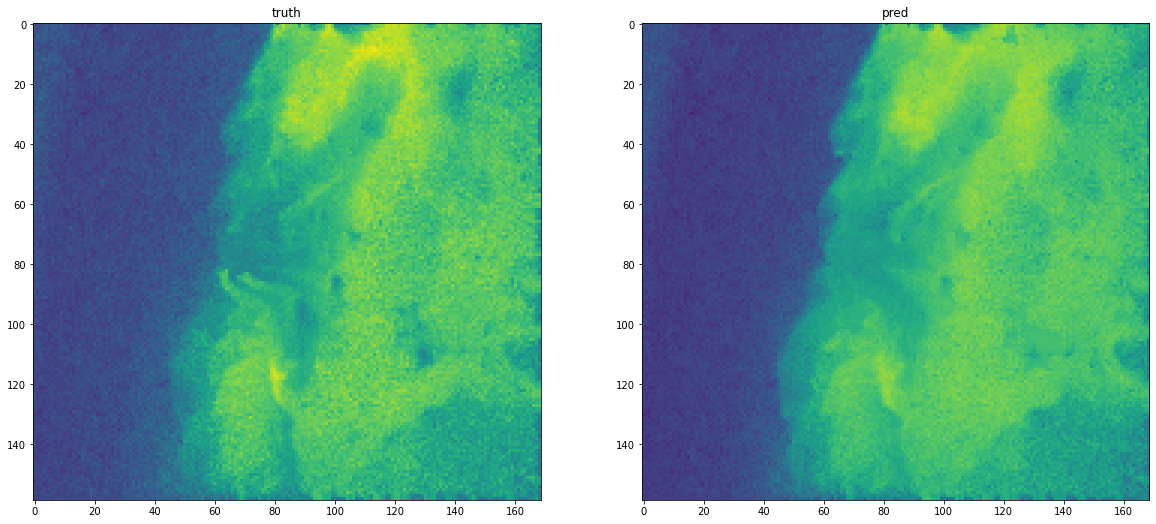

In [20]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(20,10))
ax.flat[0].imshow(truth3d[0, :,:,0], vmin=-4, vmax=4)
ax.flat[1].imshow(pred3d[0, :,:,0], vmin=-4, vmax=4)

ax.flat[0].set_title('truth')
ax.flat[1].set_title('pred')
# plt.colorbar()

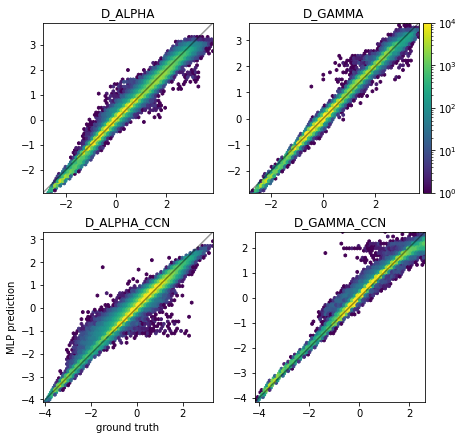

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


if len(target_idx) == 3:
    nrows=1
    ncols=3
    figsize = (10,3)
    nplots = 3
    labelix = 0
    cbarix = 2
elif len(target_idx) == 2:
    nrows = 1
    ncols = 2
    figsize = (6,3)
    nplots=2
    labelix = 0
    cbarix = 1
elif len(target_idx) == 4:
    nrows = 2
    ncols = 2
    figsize = (6,6)
    nplots=4
    labelix = 2
    cbarix = 1
    

f,axes = plt.subplots(nrows,ncols,figsize=figsize, constrained_layout=True)


for i in range(nplots):
    ax = axes.flat[i]

    _min = ytruth[:,i].min()
    _max = ytruth[:,i].max()
    im = ax.hexbin(ytruth[:,i], ypred[:,i], gridsize=64, extent=(_min,_max,_min,_max), mincnt=1, norm=colors.LogNorm(1,1e4))
#     f.colorbar(im, ax=ax, orientation='horizontal')
    ax.set_aspect(1.0)
    ax.axline([0,0], slope=1, color='k', alpha=0.4)
    ax.set_title(target_cols[i])
    ax.set_xlim(_min,_max)
    ax.set_ylim(_min,_max)

    if i==labelix:
        ax.set_xlabel('ground truth')
        ax.set_ylabel('MLP prediction')

    if i == cbarix:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(im, cax=cax)

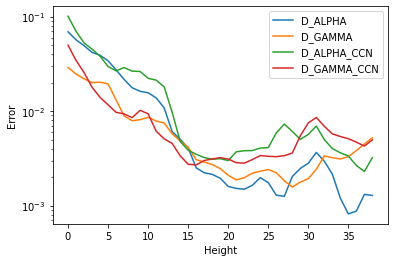

In [22]:
errors = ((truth3d - pred3d)**2).mean(axis=(1,2))
plt.semilogy(errors, label=[targcols[i] for i in target_idx ])
plt.xlabel("Height")
plt.ylabel("Error")
plt.legend()

In [24]:
datasource

'sunny'

In [ ]:
pctdiff_cube = np.abs(np.exp((truth3d - pred3d)* tstd) - 1)


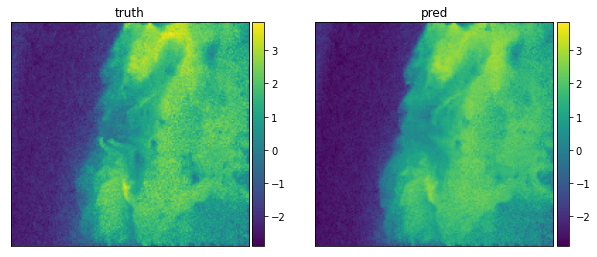

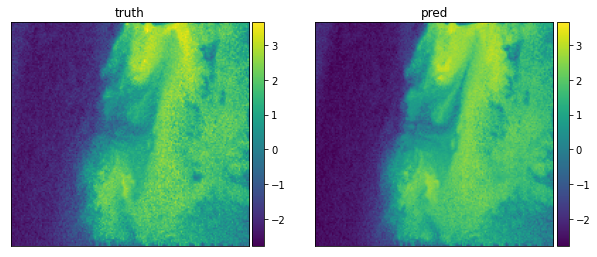

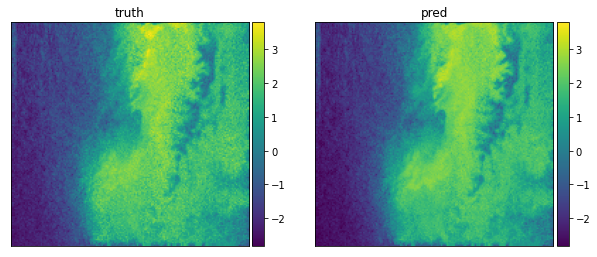

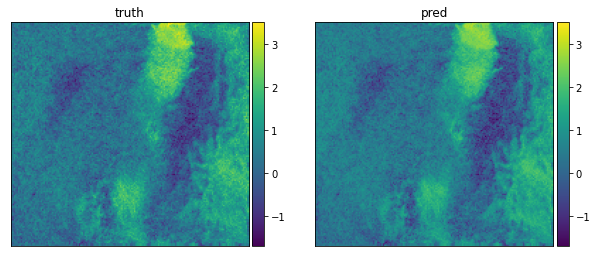

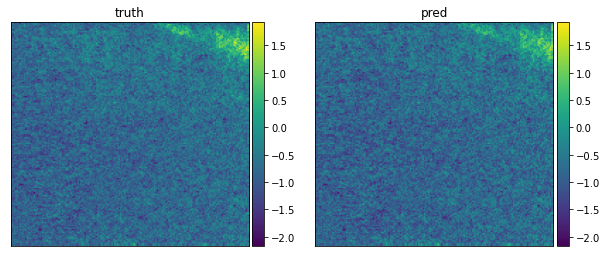

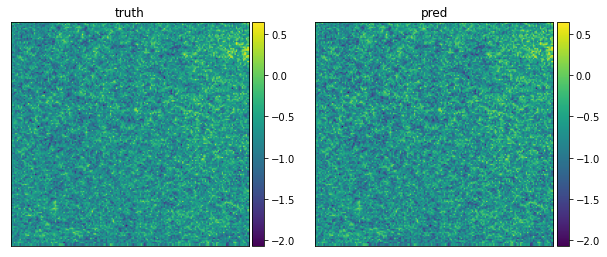

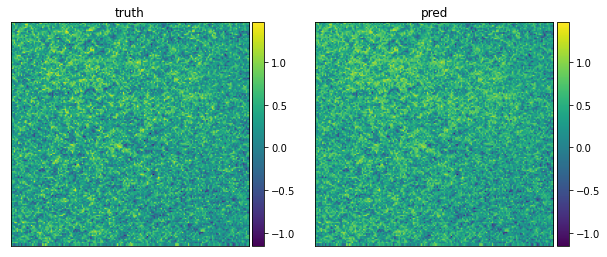

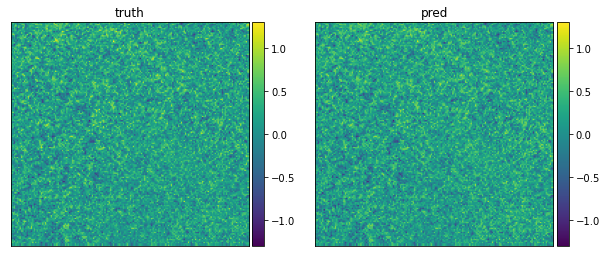

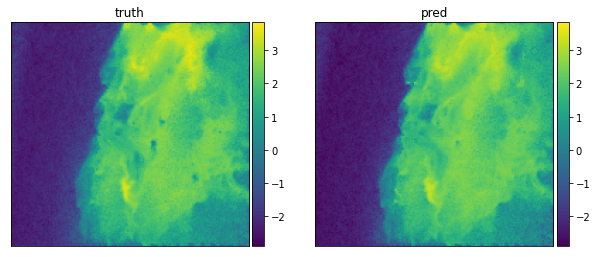

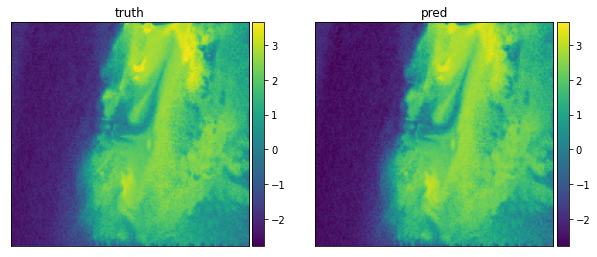

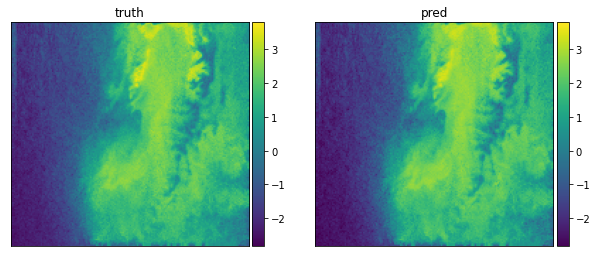

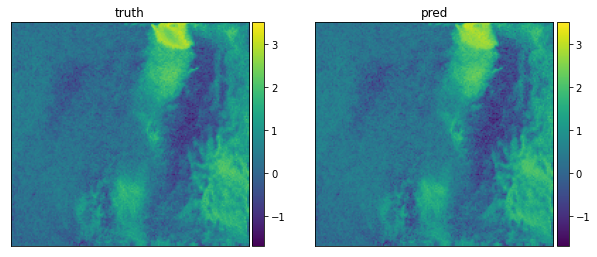

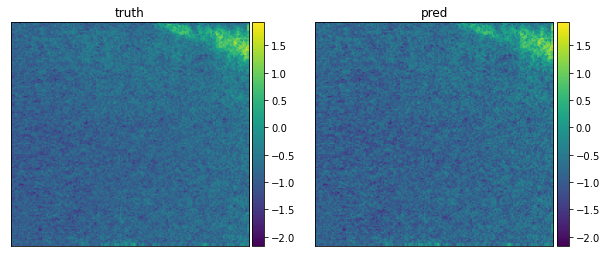

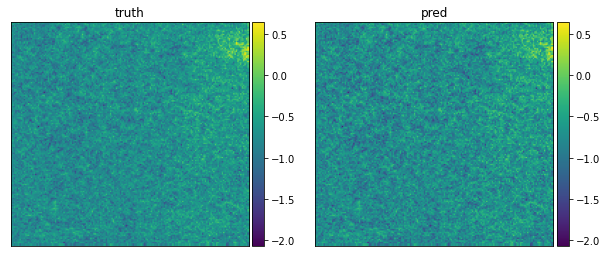

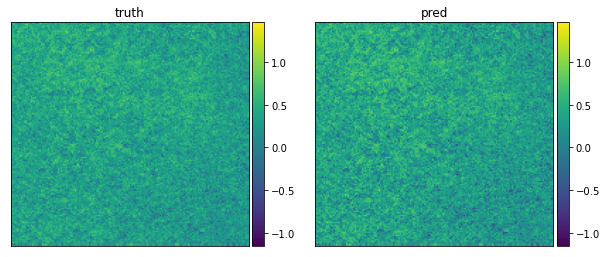

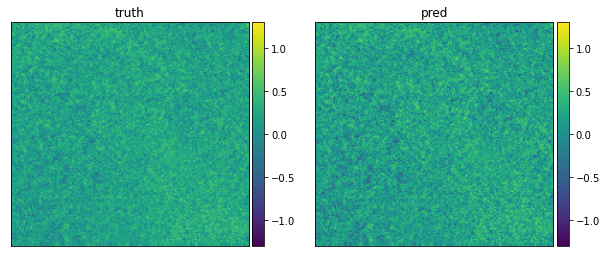

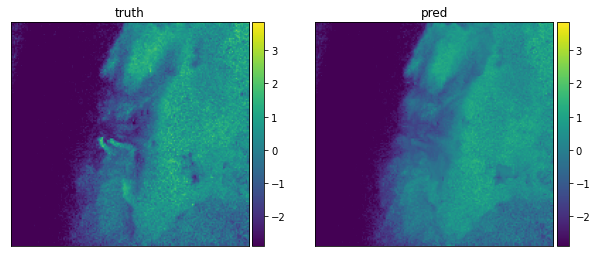

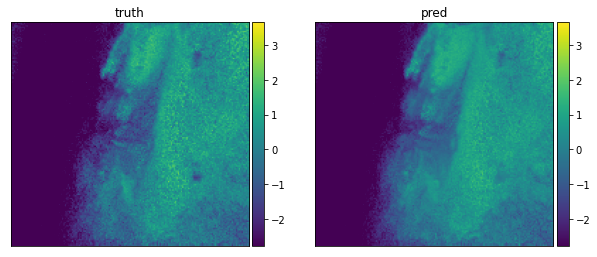

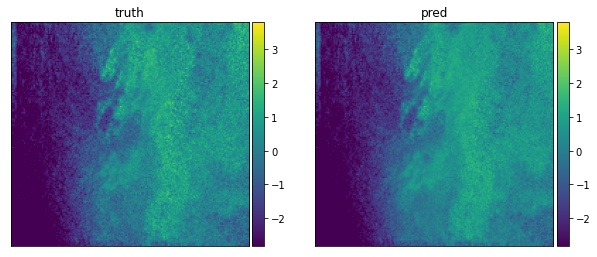

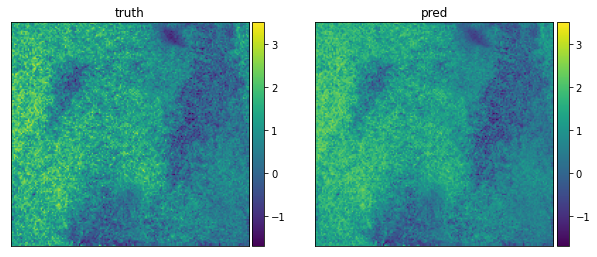

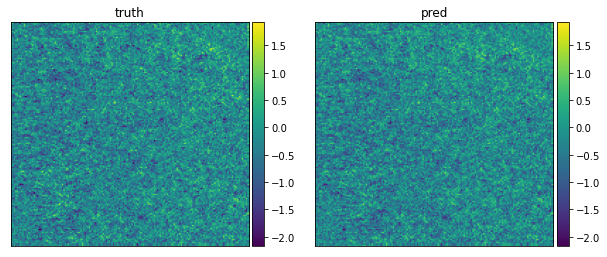

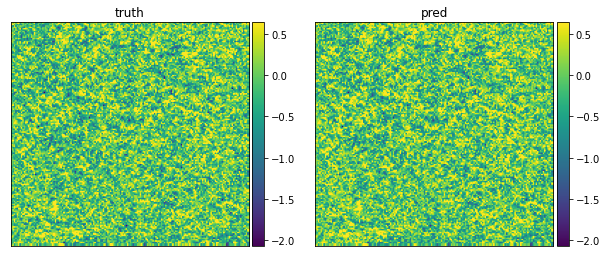

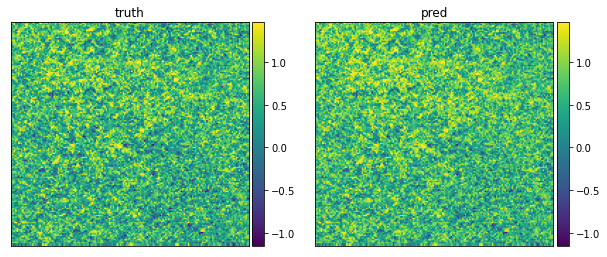

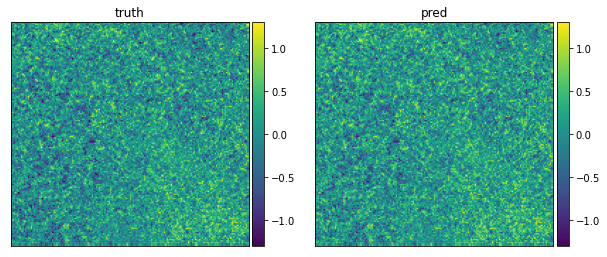

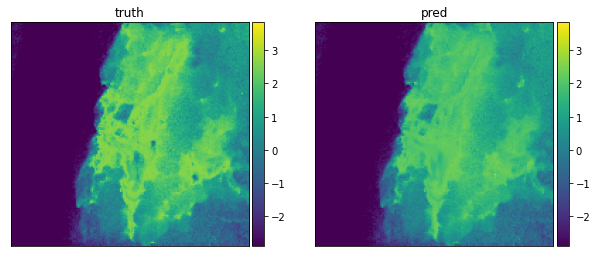

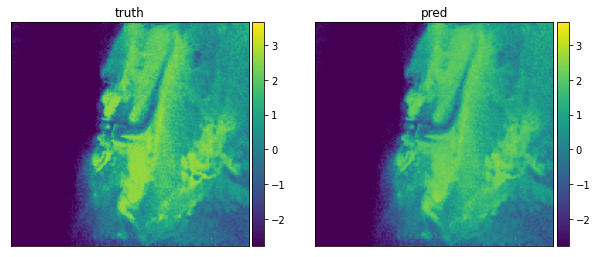

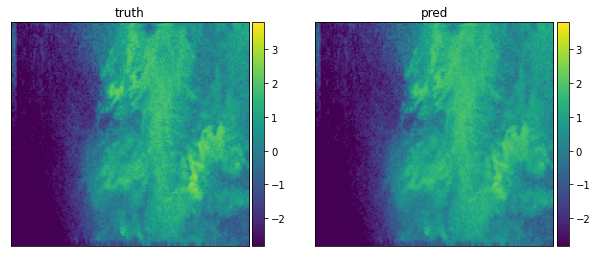

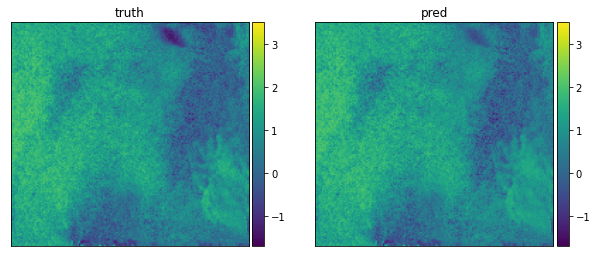

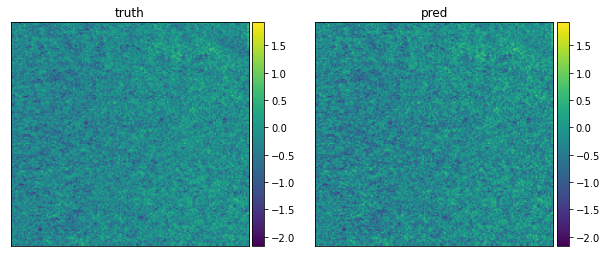

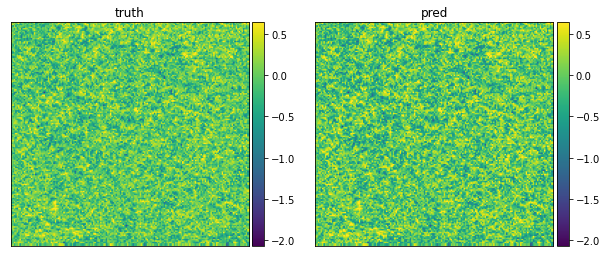

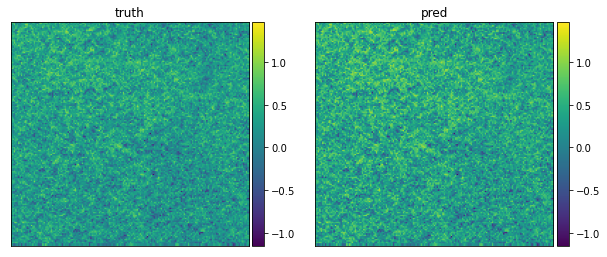

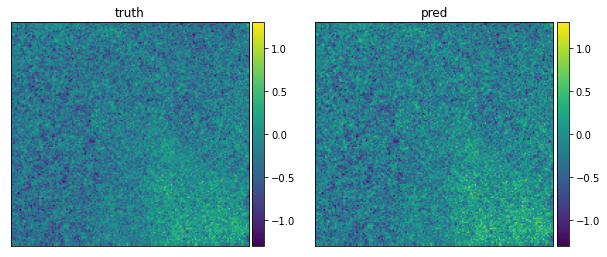

In [345]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


zslice = 10

IDX_targ = 0

for IDX_targ in range(len(target_idx)):
    for zslice in [0,2,5,10,15,20,30,35]:
        f,ax = plt.subplots(1,2, figsize=(10,5))

        td = truth3d[zslice,:,:,0]

        im1 = ax.flat[0].imshow(truth3d[zslice, :,:,IDX_targ], vmin=td.min(), vmax=td.max())
        im2 = ax.flat[1].imshow(pred3d[zslice, :,:,IDX_targ], vmin=td.min(), vmax=td.max())

        divider = make_axes_locatable(ax.flat[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = f.colorbar(im1, cax=cax, orientation='vertical')

        divider = make_axes_locatable(ax.flat[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = f.colorbar(im1, cax=cax, orientation='vertical')


        ax.flat[0].set_title('truth')
        ax.flat[1].set_title('pred')
        ax.flat[0].set_xticks([])
        ax.flat[0].set_yticks([])

        ax.flat[1].set_xticks([])
        ax.flat[1].set_yticks([])
        # plt.colorbar()
        plt.show()
        plt.close(f)
# plt.close('all')